In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
import seaborn as sns
import gensim

In [2]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adagrad

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/My Drive/Dataset/dataset.csv")

In [8]:
preprocessed_data = preprocess(data)

Word2Vec vectorization

In [9]:
vocab_size = 10000
max_length = 1500
dim = 64  # dimension of vector after vectorization

In [10]:
def w2v(preprocessed_data):
    # Convert label into an array. y is a target variable
    y = preprocessed_data['label'].values
    x = [d.split() for d in preprocessed_data['content'].tolist()]


    # Create Word2Vec model
    w2v_model = gensim.models.Word2Vec(sentences=x, vector_size=dim, window=10, min_count=2)

    # Convert into sequence of texts
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)  # Assigns unique integer index to each unique word in text

    # Convert into sequence of numbers
    x_sequences = tokenizer.texts_to_sequences(x)

    # Get the word index mapping
    word_index = tokenizer.word_index


    x_padding = pad_sequences(x_sequences, maxlen=max_length)          #padding the sequences
    #Determine vocabulary size

    vocab = tokenizer.word_index

    #return w2v_model, x_padding, word_index

    weight_matrix = np.zeros((vocab_size, dim))

    for word, i in vocab.items():
      if i < weight_matrix.shape[0]:
        weight_matrix[i] = w2v_model.wv[word]

    return weight_matrix, x_padding, y, w2v_model

In [11]:
weight_matrix, x, y, w2v_model = w2v(preprocessed_data)

In [12]:
w2v_model.save('/content/drive/MyDrive/w2v_model_50e')

In [ ]:
#weight_matrix.shape

Feed vectors from w2v_model as initial weights to lstm and it again recreates the vector. This improves accuracy

Epoch 1/80
1243/1243 [==============================] - 66s 51ms/step - loss: 0.6258 - accuracy: 0.6749 - val_loss: 0.5696 - val_accuracy: 0.7502
Epoch 2/80
1243/1243 [==============================] - 64s 51ms/step - loss: 0.5355 - accuracy: 0.7834 - val_loss: 0.5115 - val_accuracy: 0.8009
Epoch 3/80
1243/1243 [==============================] - 63s 51ms/step - loss: 0.4908 - accuracy: 0.8143 - val_loss: 0.4764 - val_accuracy: 0.8156
Epoch 4/80
1243/1243 [==============================] - 61s 49ms/step - loss: 0.4616 - accuracy: 0.8287 - val_loss: 0.4520 - val_accuracy: 0.8258
Epoch 5/80
1243/1243 [==============================] - 64s 51ms/step - loss: 0.4404 - accuracy: 0.8358 - val_loss: 0.4337 - val_accuracy: 0.8305
Epoch 6/80
1243/1243 [==============================] - 63s 51ms/step - loss: 0.4241 - accuracy: 0.8404 - val_loss: 0.4192 - val_accuracy: 0.8328
Epoch 7/80
1243/1243 [==============================] - 61s 49ms/step - loss: 0.4109 - accuracy: 0.8431 - val_loss: 0.4075 -

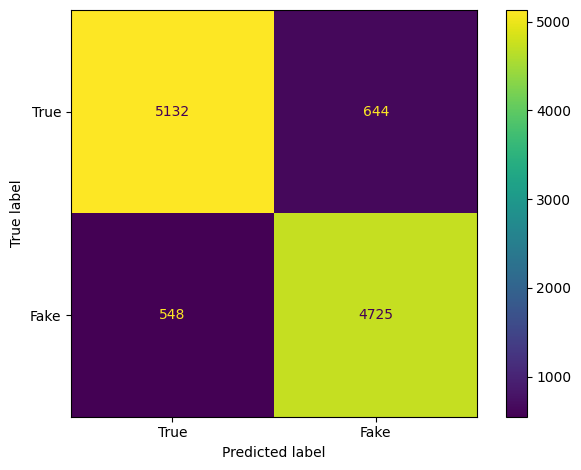

In [39]:
def create_train_evaluate_lstm(x, y, weight_matrix, vocab_size, dim, max_length, epochs=80, validation_split=0.1):
    # Splitting the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    # Create LSTM model
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=dim, weights=[weight_matrix], input_length=max_length, trainable=False))
    model.add(LSTM(140))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adagrad(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Training the LSTM model
    history = model.fit(x_train, y_train, epochs=epochs, validation_split=validation_split)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test)

    # Make predictions on the test set
    y_pred = (model.predict(x_test) >= 0.5).astype(int)

    # Print classification report
    print('Classification Report:\n', classification_report(y_test, y_pred))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix =cm, display_labels =['True', 'Fake'])
    cm_display.plot()
    plt.tight_layout()
    plt.show()

    return model, history, test_loss, test_accuracy

model, history, test_loss, test_accuracy = create_train_evaluate_lstm(x, y, weight_matrix, vocab_size, dim, max_length)


In [44]:
import joblib

In [45]:
# save the model to disk
filename = '/content/drive/My Drive/finalized_lstm_model_80e.sav'
joblib.dump(model, filename)

['/content/drive/My Drive/finalized_lstm_model_80e.sav']

In [46]:
model.save('/content/drive/My Drive/final_model_80e.h5')

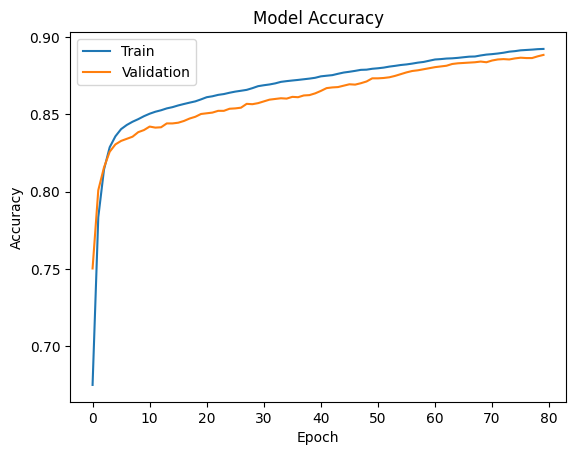

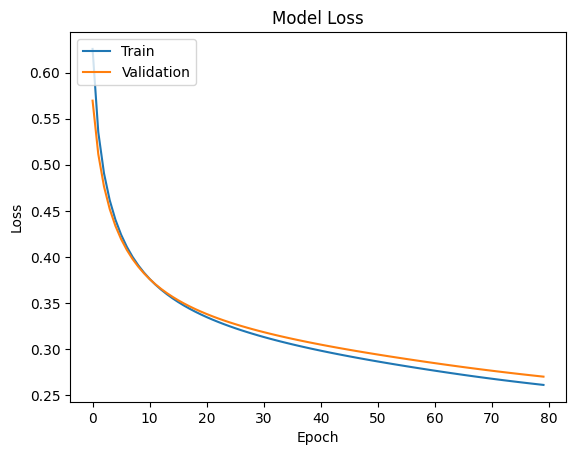

In [47]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model1 = load_model('/content/final_model.h5')

In [33]:
# Single news text
news_text = 'Feb 21 (Reuters) - Republican U.S. presidential candidate Nikki Haley said on Wednesday she believed frozen embryos created through in-vitro fertilization were babies, in comments seen as backing a controversial ruling by the Alabama Supreme Court.Haley addressed the issue in a pair of TV interviews hours apart, days after Alabamas high court said that frozen embryos in test tubes should be considered children, rattling doctors and patients in reproductive medicine as well as raising legal questions.Embryos, to me, are babies, Haley told NBC News. When you talk about an embryo, you are talking about, to me, thats a life. And so I do see where thats coming from when they talk about that.Asked in a CNN interview later on Wednesday about the remarks, she said: I didnt say that I agreed with the Alabama ruling.Later, she added, Our goal is to always do what the parents want with their embryo. It is theirs.The former South Carolina governor said she had her son after using artificial insemination, a different procedure which does not involve embryos in a lab.Haley is the last major 2024 Republican presidential challenger to frontrunner Donald Trump. The two will face off a third time on Saturday in her home state of South Carolina, with Haley again trailing in opinion polls but refusing to drop out.Trump has not publicly mentioned the Alabama ruling. A representative for his campaign did not immediately respond to a request for comment.The ruling was greeted by widespread shock in Alabama, which has one of the nations strictest abortion laws, according to news reports, with patients confused about whether to proceed with IVF and others wondering whether to move their embryos.The University of Alabama at Birmingham paused in-vitro fertilization after the state supreme court ruling, due to fear of prosecution and lawsuits, a hospital representative said.'


In [18]:
news_text = 'The above function simply returns the information in row 0. This is useful, but since the data is labeled, we can also use the loc function:'

In [27]:
def cleanText(news_text):
  news = news_text.lower()
  #Removing special characters
  news = re.sub(r'[^a-zA-Z\s]', '', news)
  #Remove stopwords
  stop_word = set(stopwords.words('english'))
  news =' '.join([word for word in news.split() if word not in stop_word])
  #lemmatization
  lemmatizer = WordNetLemmatizer()
  news = ' '.join([lemmatizer.lemmatize(word) for word in news.split()])
  return news
clean_news = cleanText(news_text)

In [34]:
tokenized_text = clean_news.split()

print(tokenized_text)

['feb', 'reuters', 'republican', 'u', 'presidential', 'candidate', 'nikki', 'haley', 'said', 'wednesday', 'believed', 'frozen', 'embryo', 'created', 'invitro', 'fertilization', 'baby', 'comment', 'seen', 'backing', 'controversial', 'ruling', 'alabama', 'supreme', 'courthaley', 'addressed', 'issue', 'pair', 'tv', 'interview', 'hour', 'apart', 'day', 'alabama', 'high', 'court', 'said', 'frozen', 'embryo', 'test', 'tube', 'considered', 'child', 'rattling', 'doctor', 'patient', 'reproductive', 'medicine', 'well', 'raising', 'legal', 'questionsembryos', 'baby', 'haley', 'told', 'nbc', 'news', 'talk', 'embryo', 'talking', 'thats', 'life', 'see', 'thats', 'coming', 'talk', 'thatasked', 'cnn', 'interview', 'later', 'wednesday', 'remark', 'said', 'didnt', 'say', 'agreed', 'alabama', 'rulinglater', 'added', 'goal', 'always', 'parent', 'want', 'embryo', 'theirsthe', 'former', 'south', 'carolina', 'governor', 'said', 'son', 'using', 'artificial', 'insemination', 'different', 'procedure', 'involve'

In [35]:
word_vectors = [w2v_model.wv.get_vector(word) for word in tokenized_text if word in w2v_model.wv.key_to_index]

print(word_vectors)

[array([ 1.91329217e+00, -6.32905513e-02, -7.31228948e-01,  1.24974287e+00,
        6.65694296e-01, -1.33599746e+00,  1.06402922e+00, -7.14107394e-01,
       -1.26219094e+00, -3.84409368e-01,  3.97707105e-01, -1.82529818e-02,
        9.99270141e-01,  1.04615605e+00, -6.67226017e-01, -2.40613651e+00,
        2.27249503e+00, -1.17459989e+00,  1.18504226e+00, -4.88827318e-01,
       -2.17026663e+00, -2.18222737e+00,  9.83692646e-01,  2.72648811e-01,
       -1.81198716e+00,  1.28289235e+00, -5.59395015e-01, -9.91978645e-01,
       -6.31063525e-03,  1.22603142e+00, -4.08438504e-01, -3.54905069e-01,
       -3.37583113e+00, -1.73769498e+00, -6.52277112e-01, -1.12617575e-01,
       -6.89253926e-01,  7.95153379e-01, -9.00578275e-02, -1.31163990e+00,
       -1.26584125e+00,  1.07771251e-03, -7.27752984e-01, -4.17332172e-01,
       -4.49163198e-01,  3.24845886e+00, -9.46833730e-01, -9.18349981e-01,
        1.87532485e+00, -1.77061892e+00, -1.13506484e+00,  2.11438513e+00,
       -5.18244267e-01, 

In [36]:
max_length = 1500
valid_word_vectors = []
for seq in word_vectors:
  valid_indices = [idx for idx in seq if 0 <= idx < 10000]
  valid_word_vectors.append(valid_indices)
word_padded= pad_sequences(valid_word_vectors, padding='post', maxlen=max_length)

prediction=model.predict(word_padded)
print(prediction)

6/6 [==============================] - 0s 40ms/step
[[0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186182]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186182]
 [0.4186183]
 [0.4186183]
 [0.4186182]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186182]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]
 [0.4186183]

In [37]:
final_prediction = np.mean(prediction)

print(final_prediction)

0.4186182


In [38]:
# Assuming prediction is a numpy array containing continuous values (probabilities)
threshold = 0.5  # You can adjust the threshold as needed

# Convert the probabilities to binary predictions (0 or 1) using the threshold
binary_predictions = (final_prediction > threshold).astype(int)

print(binary_predictions)

type(binary_predictions)

if binary_predictions == 0:
    print("Fake")
else:
    print("True")



0
Fake
